1. Apply PPCA on MNIST (or CIFAR-10) for dimensionality reduction and compare
reconstruction quality with PCA..
2. Use PPCA to handle missing values in data:   
    a. Create a synthetic dataset and introduce 10% missing values at random.   
    b. Apply PPCA to estimate missing values during EM steps.   
    c. Compare imputed values with true values (compute error).
3. Use ICA to separate mixed audio signals (cocktail party problem):    
    a. Download 2 audio files (e.g., speech + music).   
    b. Create mixed signals by applying a random mixing matrix.  
    c. Apply FastICA algorithm to separate original sources.    
    d. Compare separated signals with original signals using correlation.   
    e. Plot waveforms before and after ICA.

In [1]:
!pip install PPCA

Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.45MB/s]


Train: (10000, 784), Test: (2000, 784), Image shape: (28, 28, 1)
Sanity PCA: torch.Size([512, 784])
k=64 | PCA:  MSE=0.009227,  PSNR=21.40 dB,  time=0.19s
k=64 | PPCA: MSE=0.009256,  PSNR=21.29 dB,  time=1.79s
Original


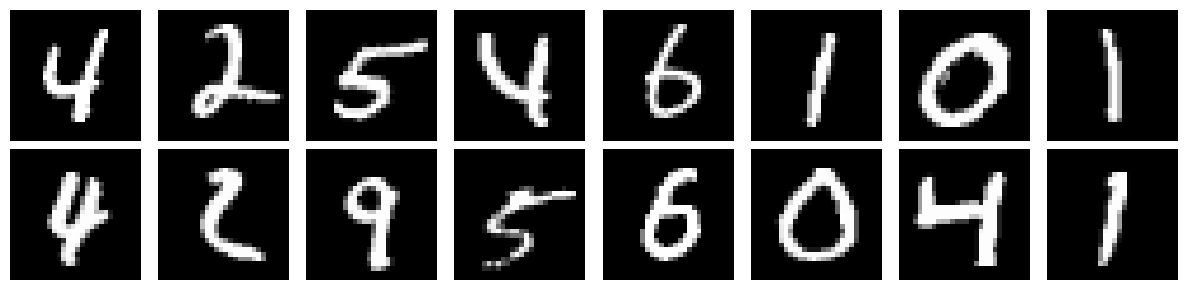

PCA recon


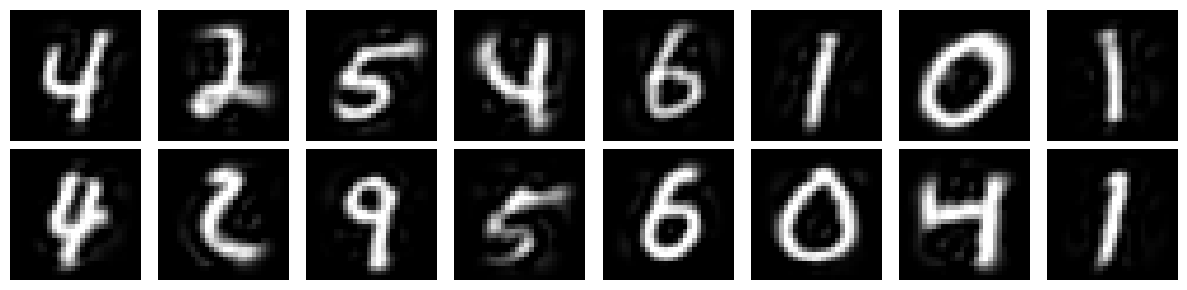

PPCA recon


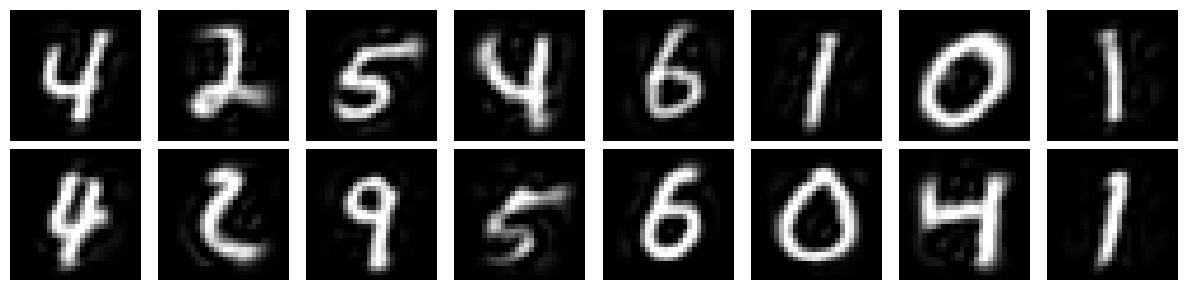

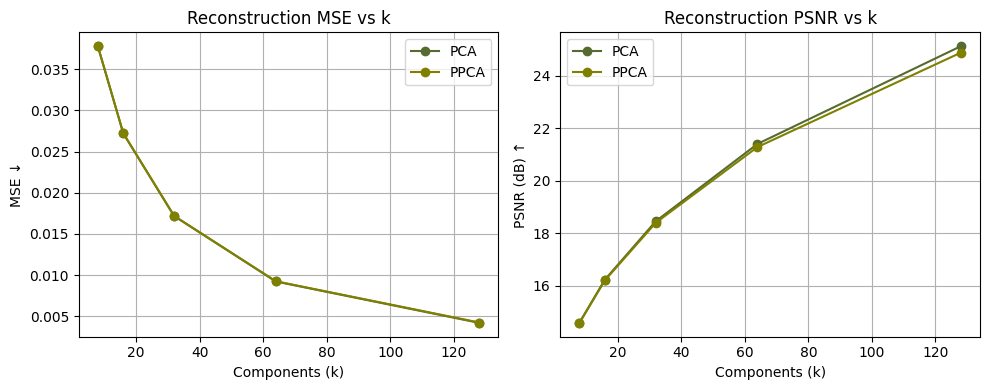

Timing (seconds) per method:
k=  8 | PCA   0.11s | PPCA   0.21s
k= 16 | PCA   0.12s | PPCA   0.24s
k= 32 | PCA   0.11s | PPCA   0.24s
k= 64 | PCA   0.11s | PPCA   0.42s
k=128 | PCA   0.12s | PPCA   0.45s
TEST MSE/PSNR
  PCA : 0.009133201092481613 21.463146209716797
  PPCA: 0.009161236695945263 21.3450870513916
Test originals


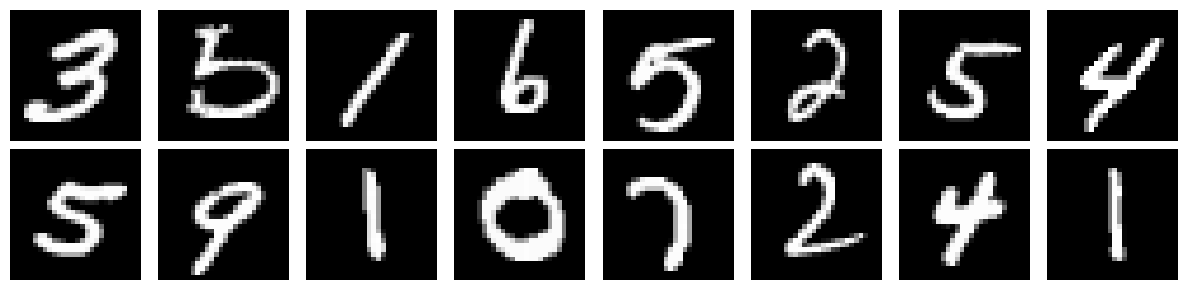

Test PCA recon


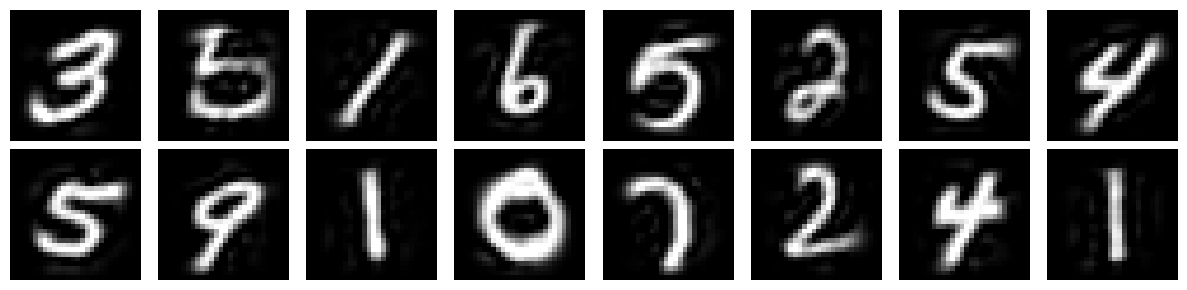

Test PPCA recon


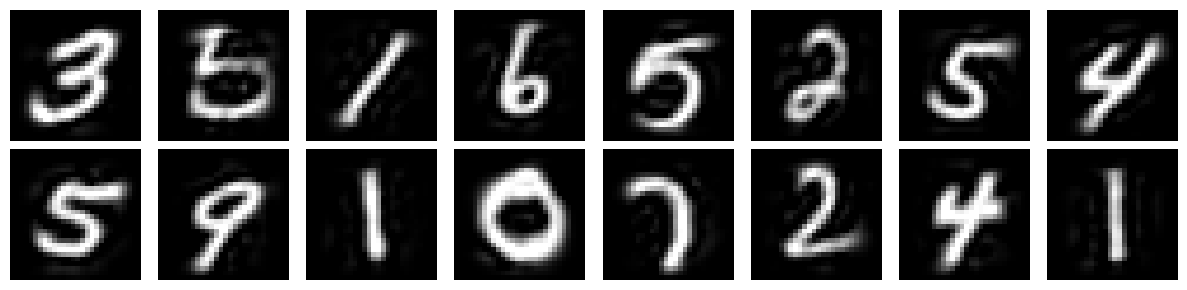

In [2]:
import os, math, time, random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm

seed_val = 42
random.seed(seed_val); np.random.seed(seed_val); torch.manual_seed(seed_val)

dataset_name = "MNIST"

# to keep EM fast; increase if you have a strong GPU
n_train_samples = 10000
n_test_samples  = 2000

components_list = [8, 16, 32, 64, 128]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if dataset_name.upper() == "MNIST":
    transform = transforms.ToTensor()  # [0,1], [1,28,28]
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    img_height, img_width, img_channels = 28, 28, 1
elif dataset_name.upper() == "CIFAR10":
    transform = transforms.ToTensor()  # [0,1], [3,32,32]
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    img_height, img_width, img_channels = 32, 32, 3
else:
    raise ValueError("dataset must be 'MNIST' or 'CIFAR10'.")

train_idx = np.random.choice(len(train_ds), size=min(n_train_samples, len(train_ds)), replace=False)
test_idx  = np.random.choice(len(test_ds),  size=min(n_test_samples, len(test_ds)),   replace=False)
train_ds  = Subset(train_ds, train_idx)
test_ds   = Subset(test_ds,  test_idx)

def ds_to_torch(dataset, device):
    X = []
    for x, _ in dataset:
        # x: [C,H,W] in [0,1]
        x = x.view(img_channels, img_height, img_width).permute(1,2,0).reshape(-1)  # flatten
        X.append(x)
    X = torch.stack(X, dim=0).to(device)  # [N, D], float32
    return X

Xtr = ds_to_torch(train_ds, device)
Xte = ds_to_torch(test_ds,  device)

n_train, data_dim = Xtr.shape
n_test = Xte.shape[0]
print(f"Train: {tuple(Xtr.shape)}, Test: {tuple(Xte.shape)}, Image shape: {(img_height,img_width,img_channels)}")

def mse_torch(a, b):
    return torch.mean((a - b) ** 2)

def batch_psnr_torch(a, b, data_range=1.0):
    # a,b in [0,1], shape [N, D]
    # compute per-image MSE then PSNR; return mean PSNR
    N = a.shape[0]
    aa = a.view(N, img_height, img_width, img_channels)
    bb = b.view(N, img_height, img_width, img_channels)
    mse_per = torch.mean((aa - bb) ** 2, dim=(1,2,3))
    eps = 1e-12
    ps = 10.0 * torch.log10((data_range ** 2) / torch.clamp(mse_per, min=eps))
    return ps.mean().item()

def show_grid(images_np, titles=None, ncols=8, vmax=1.0):
    n = len(images_np)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(1.5*ncols, 1.5*nrows))
    for i, im in enumerate(images_np):
        plt.subplot(nrows, ncols, i+1)
        if img_channels == 1:
            plt.imshow(im.reshape(img_height, img_width), cmap="gray", vmin=0, vmax=vmax)
        else:
            plt.imshow(im.reshape(img_height, img_width, img_channels))
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

def to_cpu_np(x):
    return x.detach().to("cpu").numpy()

@torch.no_grad()
def pca_reconstruct_torch(X, n_components):
    mu = X.mean(dim=0, keepdim=True)
    Xc = X - mu
    # economy SVD: Xc = U S Vh; Vh shape [D,D], but we can request full_matrices=False
    U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
    Vh_k = Vh[:n_components, :]
    S_k  = S[:n_components]
    U_k  = U[:, :n_components]
    Xc_hat = (U_k * S_k) @ Vh_k
    X_hat = Xc_hat + mu
    model = {"mu": mu, "Vh_k": Vh_k, "S_k": S_k}
    return X_hat, model

print("Sanity PCA:", pca_reconstruct_torch(Xtr[:512], 32)[0].shape)

class ppca:
    def __init__(self, n_components, tol=1e-5, max_iter=200, verbose=False, device=None):
        self.k = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.verbose = verbose
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.W = None
        self.mu = None
        self.sigma2 = None

    @torch.no_grad()
    def fit(self, X):
        X = X.to(self.device)
        N, D = X.shape
        self.mu = X.mean(dim=0)
        Xc = X - self.mu

        # init via PCA
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
        Vh_k = Vh[:self.k, :]
        # PCA loadings scaled by sqrt(eigvals)
        # eigvals of covariance ~ (S^2 / (N-1)), use S for scale
        W = (Vh_k.T * (S[:self.k] / math.sqrt(max(N-1,1e-6)))).contiguous()

        # noise variance init as avg leftover variance
        if self.k < min(N, D):
            eigvals = (S**2) / max(N-1,1e-6)
            sigma2 = torch.mean(eigvals[self.k:]).clamp(min=1e-6)
        else:
            sigma2 = torch.tensor(1e-6, device=self.device)

        Iq = torch.eye(self.k, device=self.device)
        prev_ll = -float("inf")

        for it in range(self.max_iter):
            # E-step
            # M = W^T W + sigma^2 I
            M = W.T @ W + sigma2 * Iq
            # Ez = (Xc W) M^{-1}; solve M * Ez^T = (Xc W)^T
            XW = Xc @ W
            Ez = torch.linalg.solve(M, XW.T).T
            # E[zz^T] sum = N*sigma^2 M^{-1} + Ez^T Ez
            Minv = torch.linalg.inv(M)
            Ezz_sum = N * sigma2 * Minv + Ez.T @ Ez

            # M-step
            # W_new = Xc^T Ez (Ezz_sum)^{-1}
            W_new = torch.linalg.solve(Ezz_sum.T, (Xc.T @ Ez).T).T

            # sigma^2 update
            term1 = torch.sum(Xc * Xc)
            term2 = 2.0 * torch.trace(W_new.T @ (Xc.T @ Ez))
            term3 = torch.trace((W_new.T @ W_new) @ Ezz_sum)
            sigma2_new = (term1 - term2 + term3) / (N * D)
            sigma2_new = torch.clamp(sigma2_new, min=1e-8)

            # log-likelihood
            C = W_new @ W_new.T + sigma2_new * torch.eye(D, device=self.device)
            # slogdet more stable on GPU
            sign, logdet = torch.linalg.slogdet(C)
            if sign <= 0:
                ll = -float("inf")
            else:
                invC = torch.linalg.inv(C)
                ll = -0.5 * (N * (logdet + D * math.log(2*math.pi)) + torch.sum((Xc @ invC) * Xc))

            if self.verbose and (it % 10 == 0):
                print(f"[EM {it:3d}] ll={ll.item():.3f} sigma2={sigma2_new.item():.6f}")

            if abs(ll.item() - prev_ll) < self.tol:
                W, sigma2 = W_new, sigma2_new
                break

            W, sigma2 = W_new, sigma2_new
            prev_ll = ll.item()

        self.W = W
        self.sigma2 = sigma2
        return self

    @torch.no_grad()
    def transform(self, X):
        X = X.to(self.device)
        Xc = X - self.mu
        M = self.W.T @ self.W + self.sigma2 * torch.eye(self.k, device=self.device)
        XW = Xc @ self.W
        Ez = torch.linalg.solve(M, XW.T).T
        return Ez

    @torch.no_grad()
    def inverse_transform(self, Z):
        return Z @ self.W.T + self.mu

k_val = 64  # try 32/64/128 depending on GPU memory

t0 = time.time()
Xh_pca, pca_state = pca_reconstruct_torch(Xtr, n_components=k_val)
pca_time = time.time() - t0

ppca_model = ppca(n_components=k_val, max_iter=200, tol=1e-5, verbose=False, device=device)
t0 = time.time()
ppca_model.fit(Xtr)
Ez_tr = ppca_model.transform(Xtr)
Xh_ppca = ppca_model.inverse_transform(Ez_tr)
ppca_time = time.time() - t0

# Metrics on TRAIN recon (apples-to-apples)
mse_pca  = mse_torch(Xtr, Xh_pca).item()
mse_ppca = mse_torch(Xtr, Xh_ppca).item()
psnr_pca  = batch_psnr_torch(Xtr, torch.clamp(Xh_pca, 0, 1))
psnr_ppca = batch_psnr_torch(Xtr, torch.clamp(Xh_ppca, 0, 1))

print(f"k={k_val} | PCA:  MSE={mse_pca:.6f},  PSNR={psnr_pca:.2f} dB,  time={pca_time:.2f}s")
print(f"k={k_val} | PPCA: MSE={mse_ppca:.6f},  PSNR={psnr_ppca:.2f} dB,  time={ppca_time:.2f}s")

# Visualize a few reconstructions
n_show = 16
idx = torch.randperm(n_train, device=device)[:n_show]

orig = Xtr[idx]
rec_pca = torch.clamp(Xh_pca[idx],  0, 1)
rec_ppc = torch.clamp(Xh_ppca[idx], 0, 1)

print("Original")
show_grid(to_cpu_np(orig), ncols=8)
print("PCA recon")
show_grid(to_cpu_np(rec_pca), ncols=8)
print("PPCA recon")
show_grid(to_cpu_np(rec_ppc), ncols=8)

results = {"k":[], "mse_pca":[], "psnr_pca":[], "mse_ppca":[], "psnr_ppca":[], "t_pca":[], "t_ppca":[]}

for k in components_list:
    # PCA
    t0 = time.time()
    Xh_pca, _ = pca_reconstruct_torch(Xtr, n_components=k)
    t_pca = time.time() - t0

    # PPCA
    ppca_model = ppca(n_components=k, max_iter=200, tol=1e-5, verbose=False, device=device)
    t0 = time.time()
    ppca_model.fit(Xtr)
    Ez = ppca_model.transform(Xtr)
    Xh_ppca = ppca_model.inverse_transform(Ez)
    t_ppca = time.time() - t0

    # metrics
    m_pca  = mse_torch(Xtr, Xh_pca).item()
    p_pca  = batch_psnr_torch(Xtr, torch.clamp(Xh_pca, 0,1))
    m_ppca = mse_torch(Xtr, Xh_ppca).item()
    p_ppca = batch_psnr_torch(Xtr, torch.clamp(Xh_ppca,0,1))

    results["k"].append(k)
    results["mse_pca"].append(m_pca)
    results["psnr_pca"].append(p_pca)
    results["mse_ppca"].append(m_ppca)
    results["psnr_ppca"].append(p_ppca)
    results["t_pca"].append(t_pca)
    results["t_ppca"].append(t_ppca)

# Plot
ks = results["k"]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, results["mse_pca"],  marker="o", label="PCA", color="darkolivegreen")
plt.plot(ks, results["mse_ppca"], marker="o", label="PPCA", color="olive")
plt.xlabel("Components (k)")
plt.ylabel("MSE ↓")
plt.title("Reconstruction MSE vs k")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ks, results["psnr_pca"],  marker="o", label="PCA", color="darkolivegreen")
plt.plot(ks, results["psnr_ppca"], marker="o", label="PPCA", color="olive")
plt.xlabel("Components (k)")
plt.ylabel("PSNR (dB) ↑")
plt.title("Reconstruction PSNR vs k")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

print("Timing (seconds) per method:")
for i,k in enumerate(ks):
    print(f"k={k:3d} | PCA {results['t_pca'][i]:6.2f}s | PPCA {results['t_ppca'][i]:6.2f}s")

@torch.no_grad()
def reconstruct_with_pca_state(X, state):
    mu   = state["mu"]
    Vh_k = state["Vh_k"]
    S_k  = state["S_k"]

    Xc = X - mu
    # projection Z = Xc V_k (where V_k = Vh_k^T)
    V_k = Vh_k.T
    Z   = Xc @ V_k
    # inverse transform: Xc_hat = Z V_k^T (same as low-rank proj)
    Xc_hat = Z @ V_k.T
    return Xc_hat + mu

k_val = 64

# Fit PCA once for state (re-do SVD)
_, pca_state = pca_reconstruct_torch(Xtr, n_components=k_val)

# Fit PPCA
ppca_model = ppca(n_components=k_val, max_iter=200, tol=1e-5, verbose=False, device=device).fit(Xtr)

# Reconstruct TEST
Xte_pca  = reconstruct_with_pca_state(Xte, pca_state)
Ez_te    = ppca_model.transform(Xte)
Xte_ppca = ppca_model.inverse_transform(Ez_te)

print("TEST MSE/PSNR")
print("  PCA :", mse_torch(Xte, Xte_pca).item(),  batch_psnr_torch(Xte, torch.clamp(Xte_pca,0,1)))
print("  PPCA:", mse_torch(Xte, Xte_ppca).item(), batch_psnr_torch(Xte, torch.clamp(Xte_ppca,0,1)))

idx = torch.randperm(n_test, device=device)[:16]
print("Test originals")
show_grid(to_cpu_np(Xte[idx]), ncols=8)
print("Test PCA recon")
show_grid(to_cpu_np(torch.clamp(Xte_pca[idx],0,1)), ncols=8)
print("Test PPCA recon")
show_grid(to_cpu_np(torch.clamp(Xte_ppca[idx],0,1)), ncols=8)

Using device: cuda
X: (5000, 100), observed entries: 450364/500000
[EM 000] sigma2=0.005840
Imputation RMSE on missing entries: 0.232871
Imputation MAE  on missing entries: 0.186012
Learned sigma^2: 0.000000


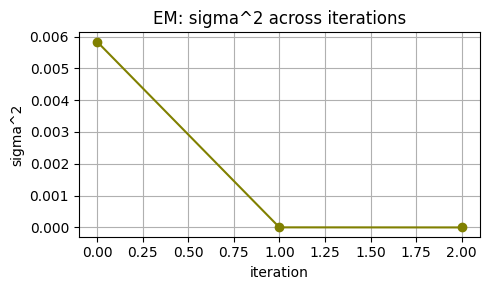

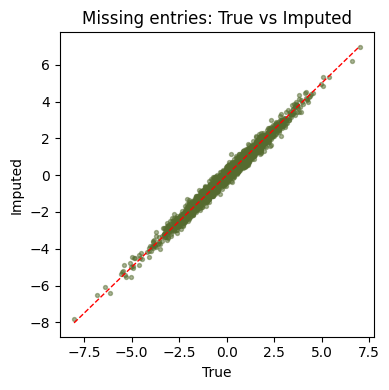

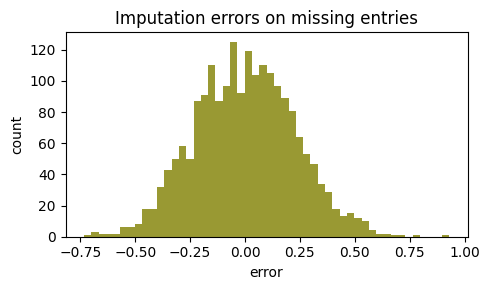

Baseline RMSEs on missing entries:
  Zero fill : 1.714031
  Mean fill : 1.705527
  PPCA fill : 0.232871


In [3]:
import math, random, numpy as np, matplotlib.pyplot as plt, torch
from tqdm import trange

seed_val = 42
random.seed(seed_val); np.random.seed(seed_val); torch.manual_seed(seed_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

def to_cpu_np(x):
    return x.detach().to("cpu").numpy()

def rmse_torch(a, b, mask=None):
    """RMSE optionally on positions where mask==1."""
    if mask is None:
        return torch.sqrt(torch.mean((a - b)**2))
    # only masked (1) entries
    dif = (a - b)[mask.bool()]
    return torch.sqrt(torch.mean(dif**2))

# Data dims
n_samples = 5000          # samples
data_dim = 100           # observed dimensionality
latent_dim = 6             # latent dimensionality
true_sigma2 = 0.05     # true noise variance

set_seed(seed_val)

# True PPCA params
w_true = torch.randn(data_dim, latent_dim, device=device) * 0.7
mu_true = torch.randn(data_dim, device=device) * 0.2

# Latents and data
z = torch.randn(n_samples, latent_dim, device=device)
x_clean = mu_true + z @ w_true.T
X = x_clean + torch.sqrt(torch.tensor(true_sigma2, device=device)) * torch.randn_like(x_clean)

# Introduce 10% missing completely at random (MCAR)
missing_rate = 0.10
mask_obs = (torch.rand(n_samples, data_dim, device=device) > missing_rate).float()  # 1=observed, 0=missing
mask_mis = 1.0 - mask_obs

# Masked view (keep observed entries, zeros elsewhere)
x_obs = X * mask_obs

print(f"X: {tuple(X.shape)}, observed entries: {mask_obs.sum().item():.0f}/{n_samples*data_dim}")

class PPCA_Missing_Torch:
    def __init__(self, k, max_iter=100, tol=1e-5, verbose=True, device=None):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.W = None
        self.mu = None
        self.sigma2 = None
        self.history = []

    @torch.no_grad()
    def _init_params(self, X, mask_obs):
        N, D = X.shape
        # per-dimension mean using only observed entries
        cnt = torch.clamp(mask_obs.sum(dim=0), min=1.0)
        mu = (X.sum(dim=0) / cnt).clone()
        # fill missing with mu for a warm start
        X_filled = torch.where(mask_obs.bool(), X, mu.unsqueeze(0).expand_as(X))

        # PCA init via SVD on centered filled data
        Xc = X_filled - mu
        # safety economy SVD (could be heavy for huge N,D)
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
        V_k = Vh[:self.k, :].T                   # [D,k]
        # scale with sqrt eigenvalues ~ S^2/(N-1)
        eig = (S[:self.k]**2) / max(N-1,1)
        W = V_k * torch.sqrt(eig).unsqueeze(0)   # [D,k]
        # noise as avg leftover var
        if self.k < min(N,D):
            sigma2 = torch.mean((S[self.k:]**2)/max(N-1,1)).clamp(min=1e-6)
        else:
            sigma2 = torch.tensor(1e-6, device=self.device)

        self.mu = mu.to(self.device)
        self.W = W.to(self.device)
        self.sigma2 = sigma2.to(self.device)

    @torch.no_grad()
    def fit(self, X, mask_obs):
        X = X.to(self.device)
        mask_obs = mask_obs.to(self.device)
        N, D = X.shape

        self._init_params(X, mask_obs)

        I_k = torch.eye(self.k, device=self.device)
        prev_ll = -float("inf")

        for it in range(self.max_iter):
            # E step
            # accumulate sufficient statistics
            sum_xhat = torch.zeros(D, device=self.device)
            Sxz = torch.zeros(D, self.k, device=self.device)
            Szz = torch.zeros(self.k, self.k, device=self.device)
            sq_center_sum = 0.0

            for n in range(N):
                m = mask_obs[n].bool()
                x_o = X[n, m]                # observed part
                mu_o = self.mu[m]
                Wn = self.W[m, :]            # [|O|,k]

                # M_n = I + (Wn^T Wn)/sigma^2
                M = I_k + (Wn.T @ Wn) / self.sigma2
                # b_n = Wn^T (x_o - mu_o)/sigma^2
                b = (Wn.T @ (x_o - mu_o)) / self.sigma2
                Ez = torch.linalg.solve(M, b)                     # [k]
                Minv = torch.linalg.inv(M)
                Ezz = self.sigma2 * Minv + torch.outer(Ez, Ez)    # [k,k]

                # Expected full xhat = mu + W Ez
                xhat = self.mu + self.W @ Ez

                sum_xhat += xhat
                Sxz += torch.outer(xhat - self.mu, Ez)
                Szz += Ezz

                # accumulate squared centered norm for sigma2 update
                sq_center_sum += torch.sum((xhat - self.mu)**2).item()

            # M step
            mu_new = (sum_xhat / N).clone()
            # center Sxz by new mu (we used old mu to accumulate; correct centering):
            # Recompute Sxz_centered = sum (xhat - mu_new) Ez^T = Sxz - N*(mu_new - mu_old) Ez_sum^T
            # but we didn't store Ez_sum; simplest is to recompute small correction:
            # (N is moderate; K small)
            Ez_sum = torch.zeros(self.k, device=self.device)
            for n in range(N):
                m = mask_obs[n].bool()
                x_o = X[n, m]
                mu_o = self.mu[m]
                Wn = self.W[m, :]
                M = I_k + (Wn.T @ Wn) / self.sigma2
                b = (Wn.T @ (x_o - mu_o)) / self.sigma2
                Ez = torch.linalg.solve(M, b)
                Ez_sum += Ez
            Sxz_centered = Sxz - torch.outer(mu_new - self.mu, Ez_sum)

            W_new = torch.linalg.solve(Szz.T, Sxz_centered.T).T   # (Sxz_centered) @ (Szz^{-1})

            # sigma^2 update
            term1 = sq_center_sum
            term2 = 2.0 * torch.trace(W_new.T @ Sxz_centered)
            term3 = torch.trace((W_new.T @ W_new) @ Szz)
            sigma2_new = (term1 - term2 + term3) / (N * D)
            sigma2_new = torch.clamp(sigma2_new, min=1e-8)

            # crude data log-likelihood proxy (optional):
            ll = -float(sigma2_new.item())  # just a monotone proxy to check progress

            self.mu, self.W, self.sigma2 = mu_new, W_new, sigma2_new

            self.history.append({"iter":it, "sigma2":float(self.sigma2.item())})
            if self.verbose and it % 5 == 0:
                print(f"[EM {it:03d}] sigma2={self.sigma2.item():.6f}")

            if abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

        return self

    @torch.no_grad()
    def transform(self, X, mask_obs):
        X = X.to(self.device)
        mask_obs = mask_obs.to(self.device)
        N, D = X.shape
        I_k = torch.eye(self.k, device=self.device)
        Ez_all = torch.zeros(N, self.k, device=self.device)

        for n in range(N):
            m = mask_obs[n].bool()
            x_o = X[n, m]
            mu_o = self.mu[m]
            Wn = self.W[m, :]
            M = I_k + (Wn.T @ Wn) / self.sigma2
            b = (Wn.T @ (x_o - mu_o)) / self.sigma2
            Ez = torch.linalg.solve(M, b)
            Ez_all[n] = Ez
        return Ez_all

    @torch.no_grad()
    def impute(self, X, mask_obs):
        Ez = self.transform(X, mask_obs)
        Xhat = self.mu + Ez @ self.W.T
        return Xhat


ppca_model = PPCA_Missing_Torch(k=latent_dim, max_iter=60, tol=1e-5, verbose=True, device=device)
ppca_model.fit(x_obs, mask_obs)

# Impute: \hat{x} = mu + W E[z|obs]
x_imp = ppca_model.impute(x_obs, mask_obs)

# Error only on the originally missing entries
rmse_missing = rmse_torch(x_imp, X, mask=mask_mis).item()
mae_missing  = torch.mean(torch.abs((x_imp - X)[mask_mis.bool()])).item()

print(f"Imputation RMSE on missing entries: {rmse_missing:.6f}")
print(f"Imputation MAE  on missing entries: {mae_missing:.6f}")
print(f"Learned sigma^2: {ppca_model.sigma2.item():.6f}")

#  1) Convergence trace
sigmas = [h["sigma2"] for h in ppca_model.history]
plt.figure(figsize=(5,3))
plt.plot(sigmas, marker="o", color="olive"); plt.grid(True)
plt.title("EM: sigma^2 across iterations")
plt.xlabel("iteration"); plt.ylabel("sigma^2")
plt.tight_layout(); plt.show()

# 2) True vs Imputed (on missing only) — subsample for scatter
idx_flat = mask_mis.view(-1).nonzero(as_tuple=False).view(-1)
sub = idx_flat[torch.randperm(len(idx_flat))[:2000]]
true_vals = X.view(-1)[sub].detach().cpu().numpy()
imp_vals  = x_imp.view(-1)[sub].detach().cpu().numpy()

plt.figure(figsize=(4,4))
plt.scatter(true_vals, imp_vals, s=8, alpha=0.5, color="darkolivegreen")
mn = min(true_vals.min(), imp_vals.min()); mx = max(true_vals.max(), imp_vals.max())
plt.plot([mn, mx],[mn, mx], 'r--', linewidth=1)
plt.xlabel("True"); plt.ylabel("Imputed")
plt.title("Missing entries: True vs Imputed")
plt.tight_layout(); plt.show()

# 3) Error histogram
errs = (imp_vals - true_vals)
plt.figure(figsize=(5,3))
plt.hist(errs, bins=50, alpha=0.8, color="olive")
plt.title("Imputation errors on missing entries")
plt.xlabel("error"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Baseline 1: Per-dimension observed-mean fill
cnt = torch.clamp(mask_obs.sum(dim=0), min=1.0)
mu_obs = (x_obs.sum(dim=0) / cnt)
x_meanfill = torch.where(mask_obs.bool(), x_obs, mu_obs)
rmse_mean = rmse_torch(x_meanfill, X, mask=mask_mis).item()

# Baseline 2: Zero fill (very naive)
x_zerofill = x_obs.clone()
rmse_zero = rmse_torch(x_zerofill, X, mask=mask_mis).item()

print(f"Baseline RMSEs on missing entries:")
print(f"  Zero fill : {rmse_zero:.6f}")
print(f"  Mean fill : {rmse_mean:.6f}")
print(f"  PPCA fill : {rmse_missing:.6f}")

Loaded sources: ['audio/src_1.wav', 'audio/src_2.wav']
Shape S: (2, 79190) Sample Rate: 16000
Mixing matrix A:
 [[ 0.30471708 -1.03998411]
 [ 0.7504512   0.94056472]]
det(A) = 1.0670634498466751
Mixtures X shape: (2, 79190)


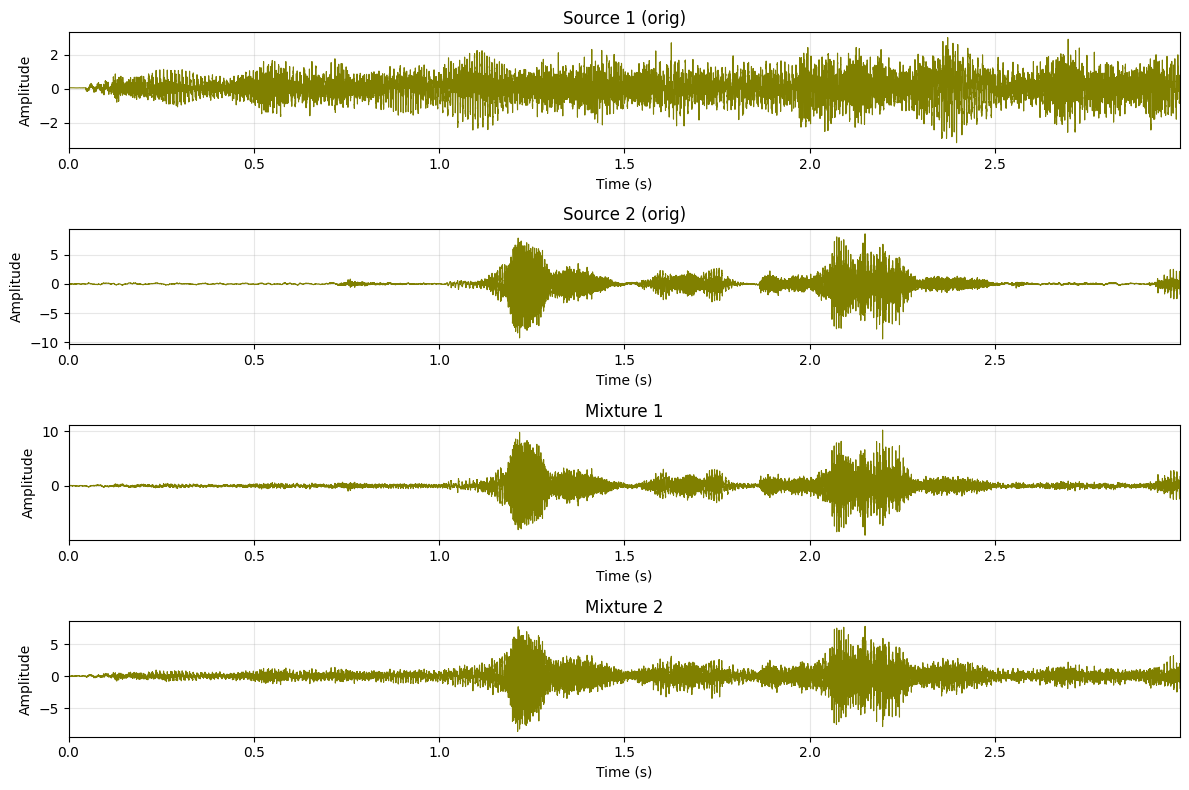

Unmixing W (approx A^{-1} up to scale/perm/sign):
 [[-0.71348446  0.27435546]
 [-1.10196182 -1.21624548]]
Best permutation: [1, 0], signs: [-1.0, 1.0]
Abs correlations (matched): 1.0000, 1.0000


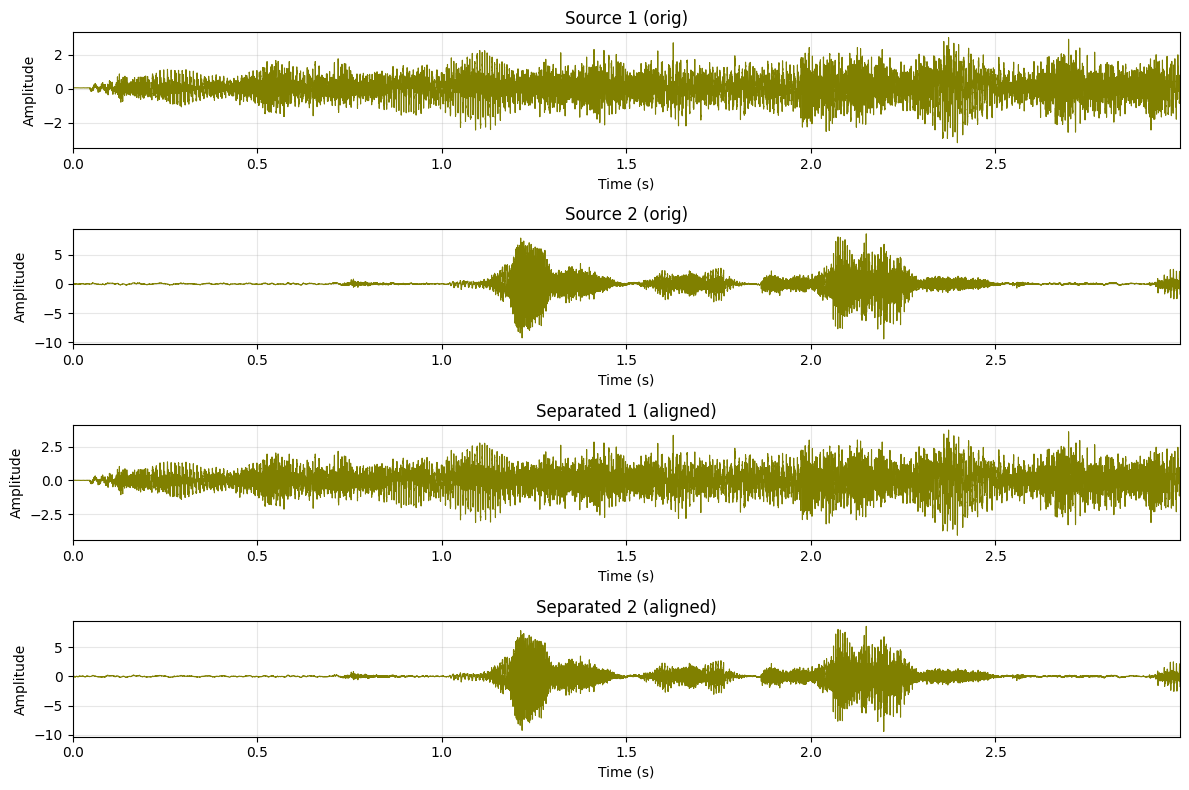

Abs correlation matrix between true sources (rows) and estimated (cols):
[[0.0021 1.    ]
 [1.     0.0092]]

Matched (after perm/sign) absolute correlations:
S1 ↔ Sep2: 1.0000
S2 ↔ Sep1: 1.0000

WAVs saved in ./outputs (mix1, mix2, sep1, sep2).


In [4]:
import os, urllib.request, numpy as np, matplotlib.pyplot as plt
import librosa, soundfile as sf
from sklearn.decomposition import FastICA

seed_val = 42
rng = np.random.default_rng(seed_val)

use_download = True

local_files = [
    "/content/vocal_score_suit.wav",
    "/content/instrumental_score_suite.wav",
]

# Downloads
audio_dir = "audio"
os.makedirs(audio_dir, exist_ok=True)
urls_list = [
    "https://github.com/rafaelreis-hotmart/Audio-Sample-files/raw/master/sample.wav",
    "https://raw.githubusercontent.com/pdx-cs-sound/wavs/master/voice.wav",    ]


target_sr = 16000       # common sample rate
max_seconds_duration = 10.0      # trim to same length for speed/clarity
plot_seconds_duration = 3.0

def download_if_needed(url, out_path):
    if not os.path.exists(out_path):
        print(f"Downloading {url} -> {out_path}")
        urllib.request.urlretrieve(url, out_path)
    else:
        print(f"Found cached: {out_path}")

def load_mono(path, sr=target_sr, max_seconds=None):
    y, sr = librosa.load(path, sr=sr, mono=True)
    if max_seconds is not None:
        y = y[: int(max_seconds * sr)]
    return y, sr

def trim_to_shortest(arrays):
    m = min(map(len, arrays))
    return [a[:m] for a in arrays]

def mix_sources(S, rng, det_min=0.3):
    assert len(S) == 2, "This demo expects exactly 2 sources."
    S = np.asarray(S)
    # Random well-conditioned 2x2 mixing
    while True:
        A = rng.normal(size=(2,2))
        if abs(np.linalg.det(A)) > det_min:
            break
    X = A @ S
    return A, X

def fastica_unmix(X):
    X_T = X.T  # [T, 2]
    ica = FastICA(n_components=2, whiten='unit-variance', random_state=seed_val, max_iter=2000)
    S_hat_T = ica.fit_transform(X_T)  # [T, 2]
    S_hat = S_hat_T.T
    W = ica.components_              # [2,2] (unmixing)
    return S_hat, W

def corr_abs(a, b):
    """Absolute Pearson correlation between two 1D arrays."""
    a = a - a.mean(); b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return abs(np.dot(a, b) / denom)

def best_permutation(S_true, S_hat):
    S_true = np.asarray(S_true); S_hat = np.asarray(S_hat)
    c00 = corr_abs(S_true[0], S_hat[0]); c01 = corr_abs(S_true[0], S_hat[1])
    c10 = corr_abs(S_true[1], S_hat[0]); c11 = corr_abs(S_true[1], S_hat[1])
    # two permutations: [0<-0, 1<-1] or [0<-1, 1<-0]
    sum_p0 = c00 + c11
    sum_p1 = c01 + c10
    if sum_p0 >= sum_p1:
        # perm [0,1]
        perm = [0,1]
        corrs = [c00, c11]
    else:
        # perm [1,0]
        perm = [1,0]
        corrs = [c01, c10]
    # Fix signs so correlation is positive
    S_aligned = np.zeros_like(S_hat)
    signs = []
    for i, j in enumerate(perm):
        s = 1.0
        if np.corrcoef(S_true[i], S_hat[j])[0,1] < 0:
            s = -1.0
        S_aligned[i] = s * S_hat[j]
        signs.append(s)
    return S_aligned, corrs, perm, signs

def plot_waveforms(rows, titles, sr, seconds=None, figsize=(12, 6)):
    if seconds is not None:
        rows = [r[: int(seconds * sr)] for r in rows]
    t_axes = [np.arange(len(r)) / sr for r in rows]
    plt.figure(figsize=figsize)
    for i, (t, r) in enumerate(zip(t_axes, rows), start=1):
        ax = plt.subplot(len(rows), 1, i)
        ax.plot(t, r, linewidth=0.8, color="olive")
        ax.set_xlim(0, t[-1] if len(t) else 1)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.set_title(titles[i-1])
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

paths = []
if use_download:
    for idx, url in enumerate(urls_list):
        out = os.path.join(audio_dir, f"src_{idx+1}.wav")
        download_if_needed(url, out)
        paths.append(out)
else:
    assert len(local_files) == 2, "Provide two paths in LOCAL_FILES."
    paths = local_files

# Load, resample, mono, trim to common length
sigs, sr = [], None
for p in paths:
    y, sr = load_mono(p, sr=target_sr, max_seconds=max_seconds_duration)
    # Normalize each source to unit std (eases ICA scaling/sign)
    y = y / (np.std(y) + 1e-12)
    sigs.append(y)

sigs = trim_to_shortest(sigs)
S = np.stack(sigs, axis=0)  # [2, T]
T = S.shape[1]
print("Loaded sources:", paths)
print("Shape S:", S.shape, "Sample Rate:", sr)

A, X = mix_sources(S, rng)
print("Mixing matrix A:\n", A)
print("det(A) =", np.linalg.det(A))
print("Mixtures X shape:", X.shape)

# Save mixes for listening
os.makedirs("outputs", exist_ok=True)
sf.write("outputs/mix1.wav", X[0], sr)
sf.write("outputs/mix2.wav", X[1], sr)

# Plot (short window)
plot_waveforms(
    [S[0], S[1], X[0], X[1]],
    ["Source 1 (orig)", "Source 2 (orig)", "Mixture 1", "Mixture 2"],
    sr, seconds=plot_seconds_duration, figsize=(12,8)
)

S_hat, W = fastica_unmix(X)
print("Unmixing W (approx A^{-1} up to scale/perm/sign):\n", W)

# Match order & sign to the original sources for evaluation
S_rec, corrs, perm, signs = best_permutation(S, S_hat)
print(f"Best permutation: {perm}, signs: {signs}")
print(f"Abs correlations (matched): {corrs[0]:.4f}, {corrs[1]:.4f}")

# Save recovered signals
sf.write("outputs/sep1.wav", S_rec[0], sr)
sf.write("outputs/sep2.wav", S_rec[1], sr)

# Plot (short window)
plot_waveforms(
    [S[0], S[1], S_rec[0], S_rec[1]],
    ["Source 1 (orig)", "Source 2 (orig)", "Separated 1 (aligned)", "Separated 2 (aligned)"],
    sr, seconds=plot_seconds_duration, figsize=(12,8)
) # Added closing parenthesis here

    # Full 2x2 absolute correlation matrix between (true) and (estimated raw)
C = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        C[i,j] = corr_abs(S[i], S_hat[j])

print("Abs correlation matrix between true sources (rows) and estimated (cols):")
print(np.round(C, 4))

print("\nMatched (after perm/sign) absolute correlations:")
print(f"S1 ↔ Sep{perm[0]+1}: {corrs[0]:.4f}")
print(f"S2 ↔ Sep{perm[1]+1}: {corrs[1]:.4f}")
print("\nWAVs saved in ./outputs (mix1, mix2, sep1, sep2).")